# NFTBank Data scientist Take-home Interview

## Part 1: Axie Infinity 도메인 지식 습득 & EDA

## 1-1 NFT 데이터 읽기

- 로컬 mysql 서버에 데이터 업로드 (인터뷰 종료 후 삭제 예정)

In [4]:
pd.set_option('mode.chained_assignment', None)
import json
from flatten_json import flatten
import timeit

### 1-1-1 mysql 서버 연결

In [5]:
from sqlalchemy import create_engine

with open("db_info.txt") as f:
    lines = f.readlines()
    db_id = lines[0].strip()
    db_pwd = lines[1].strip()
    db_ip = lines[2].strip()
    db_port = lines[3].strip()

class Engine:

    def __init__(self, db_ip = db_ip, db_port = db_port, db_id = db_id, db_pwd = db_pwd):
        self.db_ip = db_ip
        self.db_port = db_port
        self.db_id = db_id
        self.db_pwd = db_pwd

    def connect(self, db_name):
        conn = create_engine(
            "mysql+mysqldb://" + self.db_id + ":" + self.db_pwd + "@" + self.db_ip + ":" + self.db_port + "/" + db_name,
            encoding='utf-8')
        return conn    

### 1-1-2 NFT metadata load
- json line 파일을 읽기 위한 함수 생성
- 테이블 이름 정의(Database명: axie)
    - axie_financials : Axie financial events
    - axie_items : Axie item metadata
    - erc20_fx : ERC20 exchange rates 

In [6]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [7]:
# jsonl 파일 읽기 
axie_financial_jsonl = load_jsonl('axie_financial_events_20210115_v2.jsonl')
axie_items_jsonl = load_jsonl('axie_item_metadata_v2.jsonl')
erc20_fx_jsonl = load_jsonl('erc20_exchange_rates.jsonl')

Loaded 858664 records from axie_financial_events_20210115_v2.jsonl
Loaded 535022 records from axie_item_metadata_v2.jsonl
Loaded 74250 records from erc20_exchange_rates.jsonl


In [8]:
axie_items = pd.DataFrame(axie_items_jsonl)
erc20_fx = pd.DataFrame(erc20_fx_jsonl)
# axie_financial은 데이터 flatten 후 dataframe으로 만든다.

## 1.2 데이터 클렌징
### 1.2.1 데이터 flatten
- axie_financial 데이터프레임 flatten
    - transactions, items_sent, items_received, erc20s 컬럼에는 list 형태
    - 이 컬럼 내에는 가격 정보가 있으므로 flatten 필요
    - 한 거래에 여러 NFT 묶음 거래가 있는 경우, 
        - transaction1, 2 .. 등으로 생성되며
        - items_sent나 items_received, erc20s 데이터들도 번호를 붙여 생성
        - 대부분이 1개 NFT 거래라고 보여져, transaction_0, items_sent_0, items_received_0, erc20s_0 만 고려하기로 하고, 테이블 설계


In [9]:
# axie_financial 데이터를 30개로 나눠서 flatten 후 합친다
num_of_grp = 30
grp_idx = np.linspace(0, len(axie_financial_jsonl), num_of_grp)
grp_idx = np.ceil(grp_idx).astype(int)

# mysql 엔진클래스 객체 생성 및 연결
engine = Engine()
conn = engine.connect('axie')

axie_financial_cols = ['partition_id','block_timestamp','nft_transaction_hash',
                       'transactions_0_transaction_hash', 'transactions_0_block_timestamp',
                       'transactions_0_main_contract', 'transactions_0_main_function_sighash', 'transactions_0_is_nft',
                       'entity_id','event_type','transaction_type','transaction_subtype','nft_transfer_type',
                       'nft_transfer_subtype','entity_type','data_consistency_status','items_sent_0_item_id',
                       'items_sent_0_item_value','items_received_0_item_id','items_received_0_value','items_sent_count',
                       'items_received_count','item_send_transfer_type','item_receive_transfer_type','erc20s_0_erc20_contract',
                       'erc20s_0_symbol','erc20s_0_sent_amount','erc20s_0_received_amount','erc20s_0_sent_eth','erc20s_0_received_eth',
                       'erc20s_0_sent_usd','erc20s_0_received_usd','gas_used_eth','gas_used_usd','superset_id']

for i in range(num_of_grp - 1):
    start_time = timeit.default_timer()
    # 데이터 분할
    if i == (num_of_grp - 1):
        axie_jsonl_sample = axie_financial_jsonl[grp_idx[i]:len(axie_financial_jsonl)]
    else:
        axie_jsonl_sample = axie_financial_jsonl[grp_idx[i]:grp_idx[i + 1]]
    # 샘플 데이터 flatten
    axie_financial_flattened = [flatten(d) for d in axie_jsonl_sample]
    axie_financial_sample = pd.DataFrame(axie_financial_flattened)
    # 데이터 중 없는 컬럼 항목에 대해서는 (예: buy 거래의 경우 items_sent 컬럼 자체가 없음) NULL로 함
    for j in range(len(axie_financial_cols)):
        if axie_financial_cols[j] in axie_financial_sample.columns:
            pass
        else:
            axie_financial_sample.loc[:,axie_financial_cols[j]] = None
    data = axie_financial_sample[axie_financial_cols]
    # block_timestamp는 datetime형으로 변경한다.
    data['block_timestamp'] = pd.to_datetime(data['block_timestamp'])
    data['transactions_0_block_timestamp'] = pd.to_datetime(data['transactions_0_block_timestamp'])
    data.to_sql(name='axie_financials', con=conn, if_exists='append', index=False)
    terminate_time = timeit.default_timer()
    print("{i}번째 데이터 flatten이 {op_time}분 걸렸습니다".format(i=i, op_time=round((terminate_time - start_time) / 60, 2)))
conn.dispose() # db close

0번째 데이터 flatten이 0.44분 걸렸습니다
1번째 데이터 flatten이 0.38분 걸렸습니다
2번째 데이터 flatten이 0.43분 걸렸습니다
3번째 데이터 flatten이 0.36분 걸렸습니다
4번째 데이터 flatten이 0.35분 걸렸습니다
5번째 데이터 flatten이 0.41분 걸렸습니다
6번째 데이터 flatten이 0.46분 걸렸습니다
7번째 데이터 flatten이 0.38분 걸렸습니다
8번째 데이터 flatten이 0.29분 걸렸습니다
9번째 데이터 flatten이 0.38분 걸렸습니다
10번째 데이터 flatten이 0.35분 걸렸습니다
11번째 데이터 flatten이 0.35분 걸렸습니다
12번째 데이터 flatten이 0.35분 걸렸습니다
13번째 데이터 flatten이 0.37분 걸렸습니다
14번째 데이터 flatten이 0.33분 걸렸습니다
15번째 데이터 flatten이 0.32분 걸렸습니다
16번째 데이터 flatten이 1.68분 걸렸습니다
17번째 데이터 flatten이 0.42분 걸렸습니다
18번째 데이터 flatten이 0.25분 걸렸습니다
19번째 데이터 flatten이 0.31분 걸렸습니다
20번째 데이터 flatten이 0.39분 걸렸습니다
21번째 데이터 flatten이 0.34분 걸렸습니다
22번째 데이터 flatten이 0.3분 걸렸습니다
23번째 데이터 flatten이 0.28분 걸렸습니다
24번째 데이터 flatten이 0.26분 걸렸습니다
25번째 데이터 flatten이 0.26분 걸렸습니다
26번째 데이터 flatten이 0.25분 걸렸습니다
27번째 데이터 flatten이 0.26분 걸렸습니다
28번째 데이터 flatten이 0.25분 걸렸습니다


### 1.2.2 데이터형 변환
- axie_itmes 데이터의 경우 일부 bool 컬럼을 제외하고 object type (axie_items.info())
- axie_items 테이블 설계 후 db 입력

In [11]:
num_of_grp = 10
grp_idx = np.linspace(0, len(axie_items), num_of_grp)
grp_idx = np.ceil(grp_idx).astype(int)

# mysql 엔진클래스 객체 생성 및 연결
engine = Engine()
conn = engine.connect('axie')


# 데이터형 변환
items_col = ['skill', 'morale', 'speed', 'hp', 'all_parts_total_points']
items_col_append = ['move_total_points', 'move_attack', 'move_defense', 'move_accuracy']
items_col += ['mouth_' + x for x in items_col_append]  + ['horn_' + x for x in items_col_append]
items_col += ['back_' + x for x in items_col_append] + ['tail_' + x for x in items_col_append]
items_col += ['pureness']
items_col += ['total_mystic_parts_count', 'total_xmas_parts_count', 'total_bionic_parts_count']
num_of_grp = 10
for i in range(num_of_grp - 1):
    start_time = timeit.default_timer()
    if i == (num_of_grp - 1):
        axie_items_sample = axie_items.iloc[grp_idx[i]:len(axie_items)]
    else:
        axie_items_sample = axie_items.iloc[grp_idx[i]:grp_idx[i + 1]]
    axie_items_sample[items_col] = axie_items_sample[items_col].apply(pd.to_numeric, axis=1)
    # block_timestamp는 datetime형으로 변경한다.
    axie_items_sample['block_timestamp'] = pd.to_datetime(axie_items_sample['block_timestamp'])
    axie_items_sample.to_sql(name='axie_items', con=conn, if_exists='append', index=False)
    terminate_time = timeit.default_timer()
    print("{i}번째 데이터 입력이 {op_time}분 걸렸습니다".format(i=i, op_time=round((terminate_time - start_time) / 60, 2)))
conn.dispose()

0번째 데이터 입력이 0.9분 걸렸습니다
1번째 데이터 입력이 1.77분 걸렸습니다
2번째 데이터 입력이 1.28분 걸렸습니다
3번째 데이터 입력이 1.04분 걸렸습니다
4번째 데이터 입력이 1.07분 걸렸습니다
5번째 데이터 입력이 1.19분 걸렸습니다
6번째 데이터 입력이 1.15분 걸렸습니다
7번째 데이터 입력이 1.7분 걸렸습니다
8번째 데이터 입력이 0.97분 걸렸습니다


In [12]:
# erc20_fx도 데이터형을 바꿔서 저장한다.
# mysql 엔진클래스 객체 생성 및 연결
engine = Engine()
conn = engine.connect('axie')
erc20_fx['updated_at'] = pd.to_datetime(erc20_fx['updated_at'])
erc20_fx.to_sql(name='erc20_fx', con=conn, if_exists='append', index=False)
conn.dispose()

#### 데이터의 특징
- 거래데이터 
    - transaction_type: game, auction, unknown
    - transaction_subtype: breeding, matched, transfer, entered, canceled
    - nft_transfer_type: buy, receive, sell, send
    - nft_transfer_subtype: buysell, direct, unknown, non-buysell
    - entity_type:buyer, receiver, other_revenue, seller, sender
    - data_consistency_status: complete, incomplet -> 'complete' 데이터만 골라낼 것!
    
    

### 1.2.3 데이터 병합 및 결측치 처리
- 아이템의 거래 데이터(axie_financials)와 아이템 특성 데이터(axie_items)를 병합하여 가격에 영향을 미치는 요소를 알아본다.
- axie_items의 'item_id' 컬럼, 그리고 axie_financials의 'items_received_0_item_id' 혹은 'items_sent_0_item_id'컬럼과 각각 병합하되,
    - 거래 관련 블록데이터 생성일자('block_timestamp')와 아이템 특성에 관한 블록데이터 생성일자('block_timestamp')가 한 달 이내인 데이터로만 조회한다

- 데이터 중 다음의 컬럼 결측치는 0으로 처리하였다.
    - erc20의 amount 정보
        - 'erc20s_0_sent_amount', 'erc20s_0_received_amount', 
        - 'erc20s_0_sent_usd', 'erc20s_0_received_usd','gas_used_usd'
    - axie 특성 중 능력치 정보
        - 'exp', 'breedCount', 'skill', 'morale', 'speed', 'hp', 'all_parts_total_points', 
        - 'mouth_move_total_points','horn_move_total_points', 'back_move_total_points','tail_move_total_points',
        - 'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness' 
    

#### axie_financials와 axie_items를 병합한 데이터 조회

In [13]:
def get_axie_merged_df(type='sent'):
    engine = Engine()
    conn = engine.connect('axie')
    sql = "select af.block_timestamp as transaction_timestamp, af.nft_transaction_hash, af.event_type, " \
          "af.transaction_type, af.transaction_subtype,af.nft_transfer_type, af.nft_transfer_subtype, af.items_sent_0_item_id, " \
          "af.items_received_0_item_id, af.items_sent_count, af.items_received_count, " \
          "af.erc20s_0_symbol, af.erc20s_0_sent_amount, af.erc20s_0_received_amount, af.erc20s_0_sent_usd, af.erc20s_0_received_usd, " \
          "af.gas_used_usd, ai.block_timestamp as item_timestamp, ai.item_id, ai.class, ai.stage, ai.level, ai.exp, ai.breedable, ai.breedCount, " \
          "ai.skill, ai.morale, ai.speed, ai.hp, ai.all_parts_total_points, ai.mouth_move_stage, ai.mouth_move_total_points, " \
          "ai.horn_move_stage, ai.horn_move_total_points, ai.back_move_stage, ai.back_move_total_points,ai.tail_move_stage, " \
          "ai.tail_move_total_points, ai.total_mystic_parts_count, ai.total_bionic_parts_count, ai.total_xmas_parts_count, ai.pureness " \
          "from axie.axie_financials af, axie.axie_items ai " \
          "where datediff(af.block_timestamp, ai.block_timestamp) between -30 and 30 and af.data_consistency_status = 'complete' "
    if type == 'sent':
        sql += "and af.items_sent_0_item_id  = ai.item_id order by ai.item_id"
    elif type == 'received':
        sql += "and af.items_received_0_item_id  = ai.item_id order by ai.item_id"
    else:
        print('타입을 잘못 입력하였습니다.')
        return 0
    data = conn.execute(sql).fetchall()

    conn.dispose()
    axie_df = pd.DataFrame(data, columns=['transaction_timestamp', 'nft_transaction_hash', 'event_type',
          'transaction_type', 'transaction_subtype','nft_transfer_type', 'nft_transfer_subtype', 'items_sent_0_item_id',
          'items_received_0_item_id', 'items_sent_count', 'items_received_count',
          'erc20s_0_symbol', 'erc20s_0_sent_amount', 'erc20s_0_received_amount', 'erc20s_0_sent_usd', 'erc20s_0_received_usd',
          'gas_used_usd', 'item_timestamp', 'item_id', 'class', 'stage', 'level', 'exp', 'breedable', 'breedCount',
          'skill', 'morale', 'speed', 'hp', 'all_parts_total_points', 'mouth_move_stage', 'mouth_move_total_points',
          'horn_move_stage', 'horn_move_total_points', 'back_move_stage', 'back_move_total_points','tail_move_stage',
          'tail_move_total_points', 'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness'])

    # 결측치 처리
    numeric_cols = ['erc20s_0_sent_amount', 'erc20s_0_received_amount', 'erc20s_0_sent_usd', 'erc20s_0_received_usd',
          'gas_used_usd', 'exp', 'breedCount', 'skill', 'morale', 'speed', 'hp', 'all_parts_total_points', 'mouth_move_total_points',
          'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points',
            'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness' ]
    axie_df[numeric_cols] = axie_df[numeric_cols].fillna(0)
    axie_df = axie_df.astype({'transaction_timestamp': 'datetime64', 'items_sent_count':'int', 'items_received_count':'int',
                              'erc20s_0_sent_amount':'float64',
                              'erc20s_0_received_amount':'float64', 'erc20s_0_sent_usd':'float64', 'erc20s_0_received_usd':'float64',
                              'gas_used_usd':'float64', 'item_timestamp':'datetime64', 'stage':'int', 'level':'int', 'exp':'int','breedCount':'int',
                              'skill':'int', 'morale':'int', 'speed':'int', 'hp':'int', 'all_parts_total_points':'int', 'mouth_move_total_points':'int',
                              'horn_move_total_points':'int', 'back_move_total_points':'int', 'tail_move_total_points':'int',
                              'total_mystic_parts_count':'int', 'total_bionic_parts_count':'int', 'total_xmas_parts_count':'int', 'pureness':'int'})
    return axie_df

#### SLP 시계열 데이터 조회

In [14]:
def get_SLP_df():
    engine = Engine()
    conn = engine.connect('axie')
    sql = "select block_date, exchange_rate from axie.erc20_fx where currency='SLP' and vs_currency='ETH' order by block_date"
    data = conn.execute(sql).fetchall()
    conn.dispose()
    df = pd.DataFrame(data, columns=['block_date', 'exchange_rate'])
    df = df.astype({'block_date': 'datetime64', 'exchange_rate':'float64'})
    return df

In [15]:
axie_sent_df = get_axie_merged_df(type='sent')
axie_received_df = get_axie_merged_df(type='received')
# 데이터 갯수 체크
print('axie sent NFT data length:', len(axie_sent_df))
print('axie received NFT data length:', len(axie_received_df))

axie sent NFT data length: 369310
axie received NFT data length: 550414


In [16]:
SLP_df = get_SLP_df()
print('SLP data length:', len(SLP_df))

SLP data length: 1375


#### 두 데이터를 하나로 stack한다(pd.concat)
- 데이터 항목
    - 'items_sent_0_item_id','items_received_0_item_id', 'items_sent_count', 'items_received_count' 삭제
    - 'erc20s_0_amount'와 'erc20s_0_usd' 컬럼 추가
        - axie_send_df에서는 erc20s_0_received_amount, erc20s_0_received_usd
        - axie_received_df에서는 erc20s_0_sent_amount, erc20s_0_sent_usd
    - 이 때 axie_received_df는 보낸 erc20 금액이 -로 되어 있으므로, 이를 -를 붙여 보정한다.

In [17]:
axie_sent_df['erc20s_0_amount'] = axie_sent_df['erc20s_0_received_amount'].copy()
axie_sent_df['erc20s_0_usd'] = axie_sent_df['erc20s_0_received_usd'].copy()
axie_received_df['erc20s_0_amount'] =-axie_received_df['erc20s_0_sent_amount'].copy()
axie_received_df['erc20s_0_usd'] = -axie_received_df['erc20s_0_sent_usd'].copy()

In [18]:
axie_sent_df.drop(['items_sent_0_item_id','items_received_0_item_id', 'items_sent_count', 'items_received_count', 
                  'erc20s_0_sent_amount', 'erc20s_0_received_amount','erc20s_0_sent_usd', 'erc20s_0_received_usd',], axis=1, inplace=True)
axie_received_df.drop(['items_sent_0_item_id','items_received_0_item_id', 'items_sent_count', 'items_received_count', 
                  'erc20s_0_sent_amount', 'erc20s_0_received_amount','erc20s_0_sent_usd', 'erc20s_0_received_usd',], axis=1, inplace=True)

In [19]:
axie_df = pd.concat([axie_sent_df, axie_received_df], axis=0)

#### 데이터에 날짜 기간용 컬럼을 추가한다
- 년, 월

In [20]:
axie_df['year'] = axie_df['transaction_timestamp'].dt.year
axie_df['month'] = axie_df['transaction_timestamp'].dt.month

axie_df['period'] = axie_df[['year', 'month']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
axie_df.head(3)

,transaction_timestamp,nft_transaction_hash,event_type,transaction_type,transaction_subtype,nft_transfer_type,nft_transfer_subtype,erc20s_0_symbol,gas_used_usd,item_timestamp,...,tail_move_total_points,total_mystic_parts_count,total_bionic_parts_count,total_xmas_parts_count,pureness,erc20s_0_amount,erc20s_0_usd,year,month,period
0,2020-10-23 23:07:33,0x7d16cbc5d4d018c54179ea025f6329786138d0e0d3fd...,send,auction,entered,send,non-buysell,None,-1.2441,2020-10-24 07:14:58,...,120,0,0,0,5,0.0,0.0,2020,10,2020_10
1,2020-10-23 23:07:33,0x7d16cbc5d4d018c54179ea025f6329786138d0e0d3fd...,send,auction,entered,send,non-buysell,None,-1.2441,2020-10-20 08:05:29,...,120,0,0,0,5,0.0,0.0,2020,10,2020_10
2,2020-10-23 23:36:24,0x59666db35b7a64951e3a23f0383676edda686160ff18...,send,auction,entered,send,non-buysell,None,-1.3413,2020-10-24 07:14:10,...,114,0,0,0,3,0.0,0.0,2020,10,2020_10


### 1.2.4 이상값 확인
- 거래 데이터(수치데이터) 중 이상값 확인 
    - axie_sent_df의 erc20s_0_received_usd
    - axie_received_df의 erc20s_0_sent_usd

- 아이템 특성 데이터(수치데이터) 중 이상값 여부 확인
    - breedCount는 7이하여야 함
    - skill, morale, speed, hp 등 points관련 데이터. 총 능력치의 합계는 500이하여야 함?

In [21]:
axie_df[['erc20s_0_amount', 'erc20s_0_usd']].describe()

,erc20s_0_amount,erc20s_0_usd
count,919724.000000,919724.000000
mean,51.173400,43.135361
std,197.951802,736.609103
min,-0.000000,-0.000000
25%,0.000000,0.000000
50%,0.059537,24.777900
75%,0.113947,42.538100
max,5000.000000,124778.000000


C:\Users\jeyeon\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jeyeon\Anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


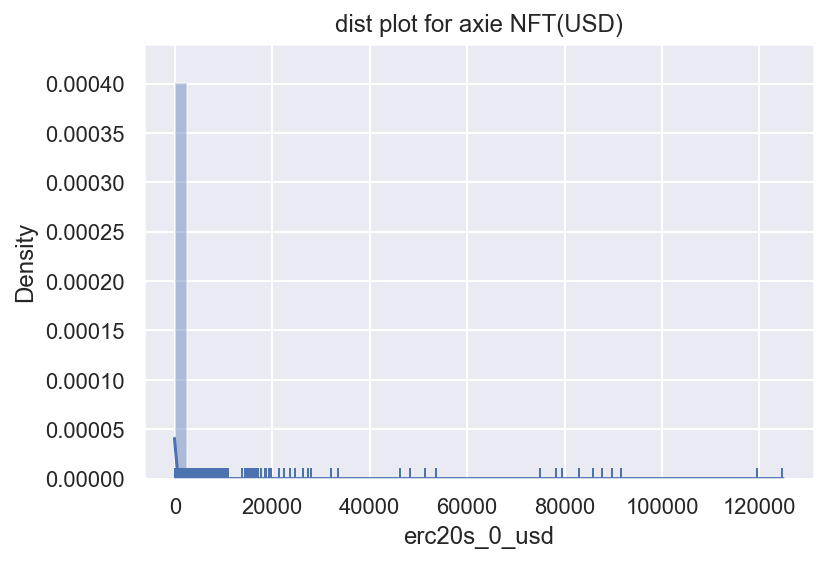

In [22]:
sns.distplot(axie_df['erc20s_0_usd'], kde=True, rug=True)
plt.title("dist plot for axie NFT(USD)")
plt.show()

C:\Users\jeyeon\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jeyeon\Anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


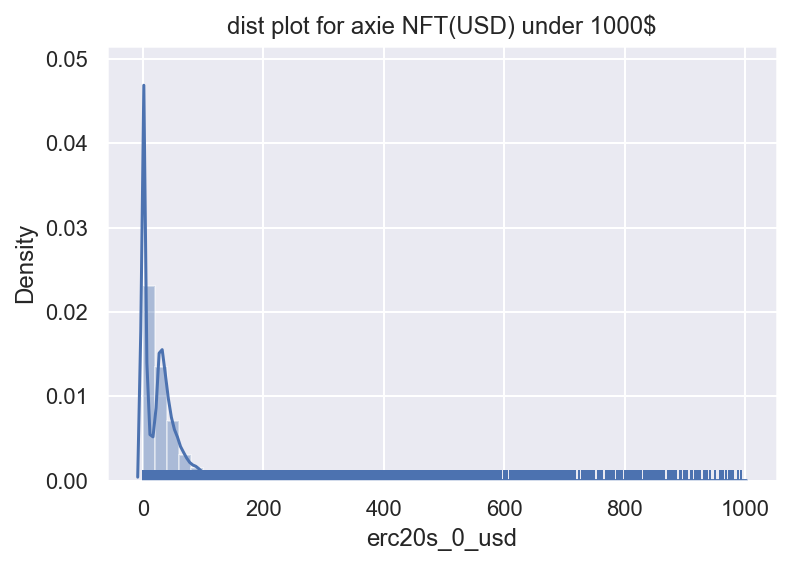

In [23]:
# 1000달러 밑으로 거래된 데이터의 distplot
axie_df_under_1000 = axie_df[axie_df['erc20s_0_usd'] < 1000].loc[:,'erc20s_0_usd']
sns.distplot(axie_df_under_1000, kde=True, rug=True)
plt.title("dist plot for axie NFT(USD) under 1000$")
plt.show()

In [24]:
axie_df[['breedCount', 'skill', 'morale', 'speed', 'hp',
       'all_parts_total_points', 'mouth_move_stage', 'mouth_move_total_points',
       'horn_move_stage', 'horn_move_total_points', 'back_move_stage',
       'back_move_total_points', 'tail_move_stage', 'tail_move_total_points',
       'total_mystic_parts_count', 'total_bionic_parts_count',
       'total_xmas_parts_count', 'pureness']].describe()

,breedCount,skill,morale,speed,hp,all_parts_total_points,mouth_move_total_points,horn_move_total_points,back_move_total_points,tail_move_total_points,total_mystic_parts_count,total_bionic_parts_count,total_xmas_parts_count,pureness
count,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000,919724.000000
mean,1.706549,26.359248,35.028855,35.664481,34.618130,350.998286,86.755501,88.706099,88.249927,87.286760,0.011250,0.000010,0.000545,2.054930
std,1.824128,13.249115,19.179524,19.512524,19.848299,174.681513,43.453945,44.386819,44.074773,43.640927,0.135838,0.003128,0.024954,1.552051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,30.000000,32.000000,27.000000,409.000000,99.000000,99.000000,100.000000,97.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,31.000000,41.000000,41.000000,38.000000,431.000000,106.000000,108.000000,106.000000,107.000000,0.000000,0.000000,0.000000,2.000000
75%,3.000000,35.000000,45.000000,48.000000,51.000000,447.000000,113.000000,115.000000,114.000000,114.000000,0.000000,0.000000,0.000000,3.000000
max,7.000000,43.000000,61.000000,61.000000,61.000000,477.000000,121.000000,120.000000,119.000000,121.000000,4.000000,1.000000,2.000000,6.000000


In [25]:
axie_df['class'].unique()

array(['beast', 'aquatic', 'bird', 'reptile', 'bug', 'plant', 'hidden_2',
       'hidden_3', 'hidden_1', None], dtype=object)

In [26]:
axie_df['transaction_type'].unique()

array(['auction', 'unknown', None, 'game'], dtype=object)

## 1.3 탐색적 데이터 분석
### 1.3.1 시계열 데이터
- 시간 흐름에 따른 가격 움직임

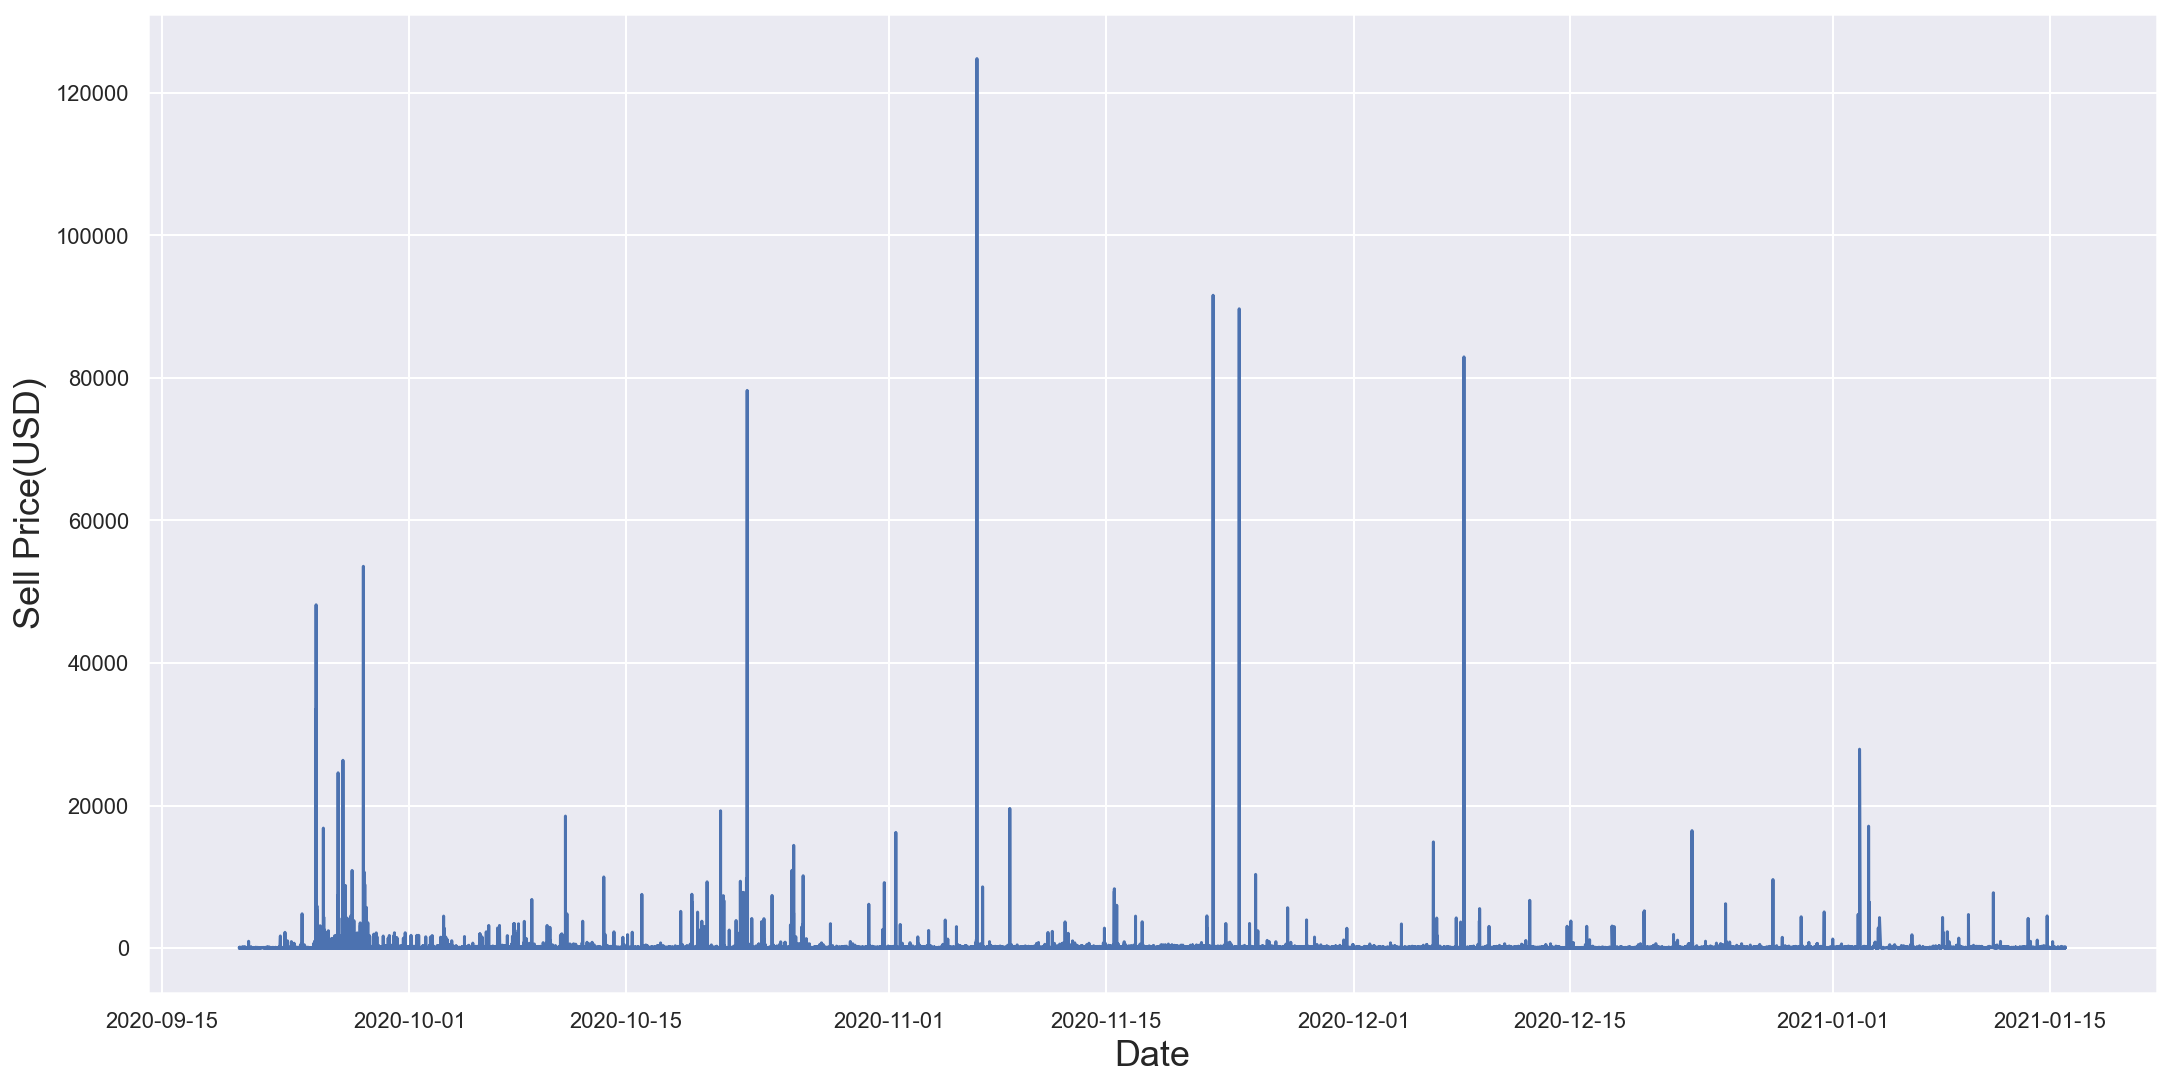

In [27]:
# 거래 block_timestamp로 데이터를 정렬한다.
axie_df = axie_df.sort_values('transaction_timestamp')

plt.figure(figsize = (18,9))
plt.plot(axie_df['transaction_timestamp'], axie_df['erc20s_0_usd'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Sell Price(USD)',fontsize=18)
plt.show()

#### 시간 흐름에 따른 SLP의 ETH대비 교환비율
- axie NFT 거래 데이터와 함께 그린다.
- SLP는 게임 내에서 axie NFT 거래에 사용, ETH는 게임, 경매에서 사용 가능
- SLP의 ETH 교환비율과 게임과 옥션에서의 거래량 추이를 같이 본다.

In [28]:
axie_df.pivot_table(values='item_id', index='transaction_type', columns='transaction_subtype', aggfunc=len)

transaction_subtype,breeding,canceled,entered,matched
transaction_type,,,,
auction,NaN,105526.0,124572.0,485758.0
game,200153.0,NaN,NaN,NaN


In [29]:
axie_df.pivot_table(values='item_id', index='transaction_type', columns='erc20s_0_symbol', aggfunc=len)

erc20s_0_symbol,ETH,SLP
transaction_type,,
auction,485758.0,NaN
game,100056.0,100097.0
unknown,2505.0,NaN


In [30]:
SLP_df = SLP_df[SLP_df['block_date'] >= '2020-09-20']

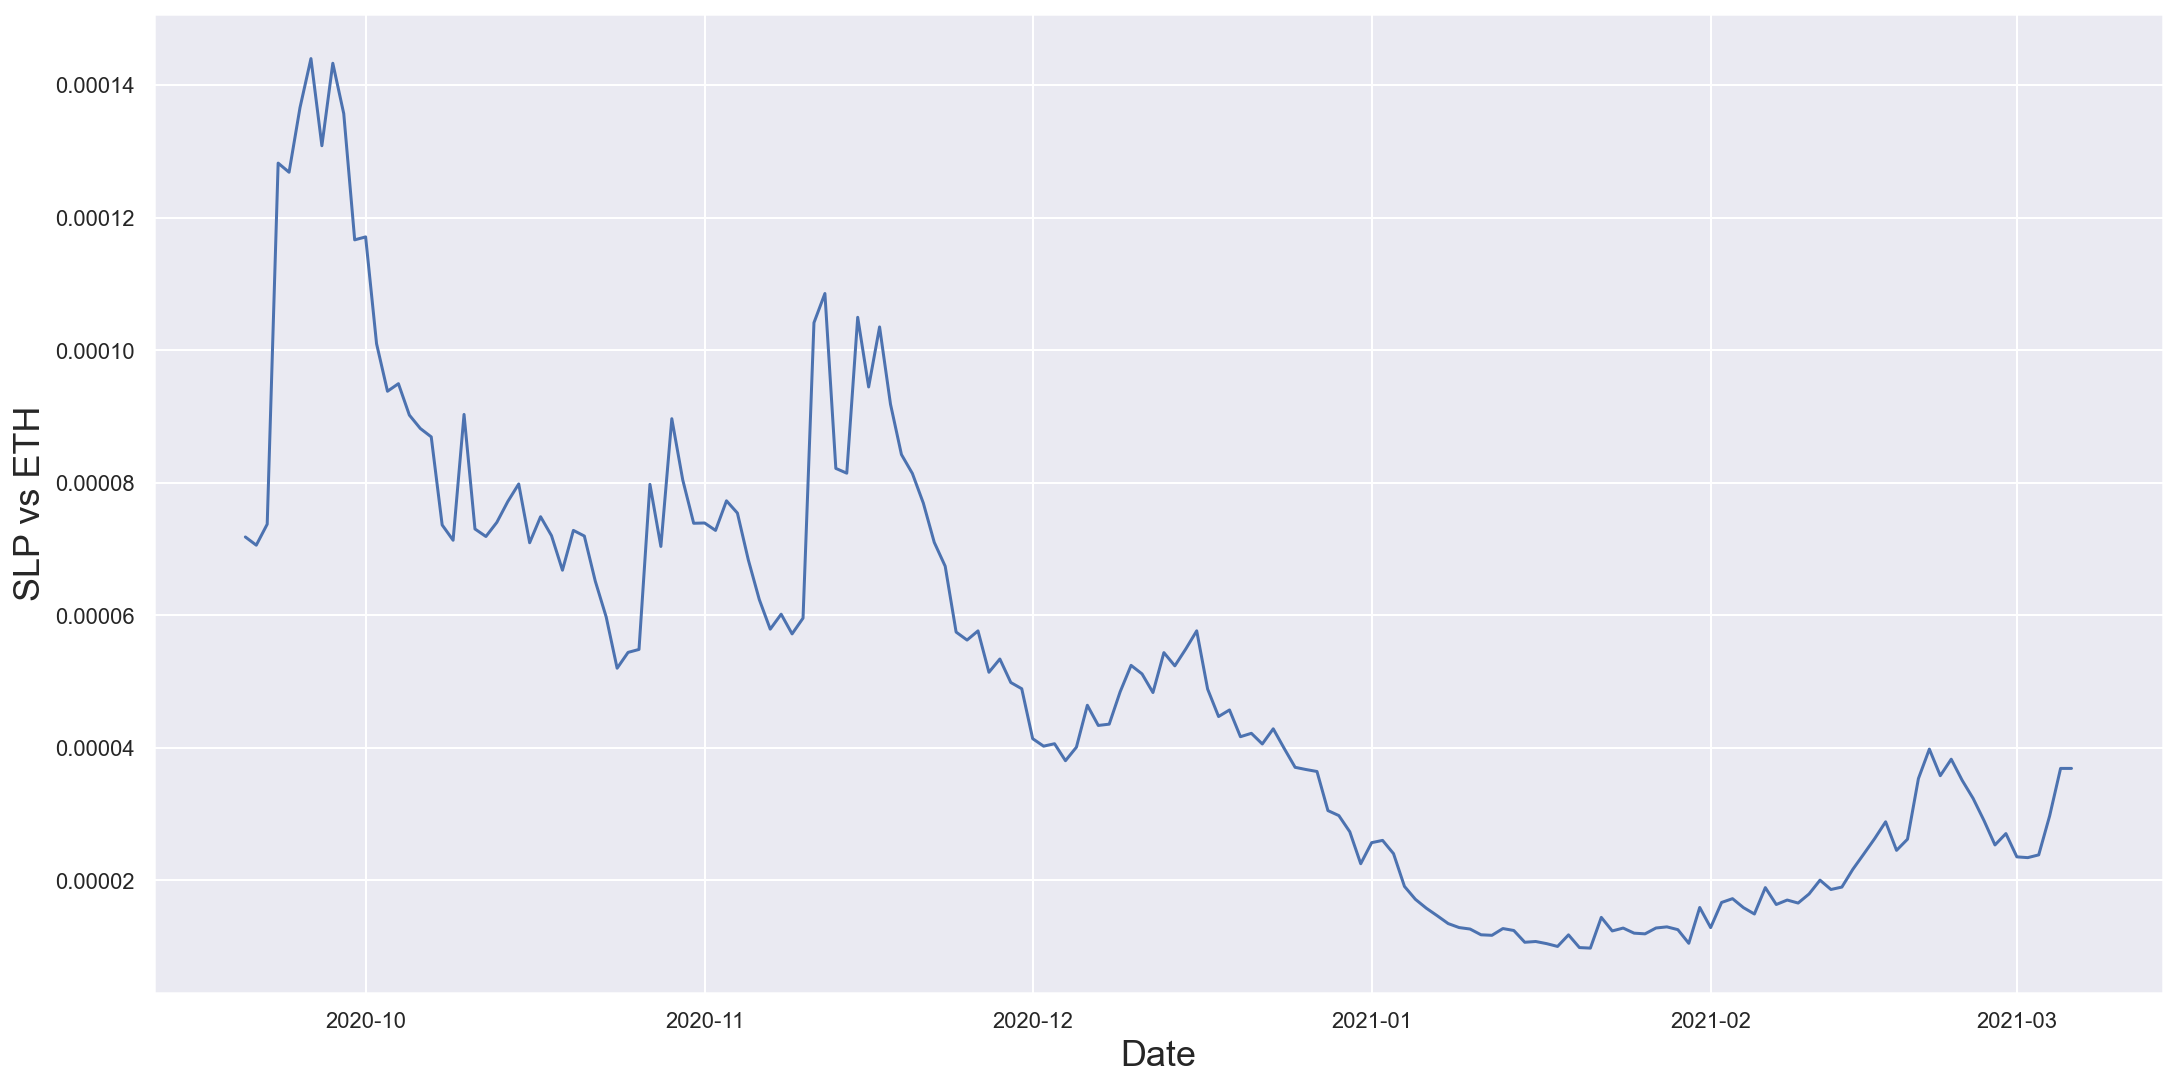

In [31]:
plt.figure(figsize = (18,9))
plt.plot(SLP_df['block_date'], SLP_df['exchange_rate'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('SLP vs ETH',fontsize=18)
plt.show()

In [32]:
axie_df['transaction_date'] = pd.to_datetime(axie_df['transaction_timestamp']).dt.date
axie_df['transaction_date'] = pd.to_datetime(axie_df['transaction_date'])

In [33]:
axie_volume = axie_df.pivot_table(values='item_id', index='transaction_date', columns='transaction_type', aggfunc=len)

In [34]:
axie_volume

transaction_type,auction,game,unknown
transaction_date,,,
2020-09-20,697.0,105.0,30.0
2020-09-21,827.0,101.0,26.0
2020-09-22,738.0,117.0,10.0
2020-09-23,1222.0,33.0,62.0
2020-09-24,1078.0,90.0,56.0
...,...,...,...
2021-01-11,686.0,18.0,NaN
2021-01-12,1670.0,303.0,8.0
2021-01-13,1991.0,993.0,6.0


- SLP/ETH 가격 추이 + 게임 내에서의 거래량(매수/매도)

<Figure size 1296x648 with 0 Axes>

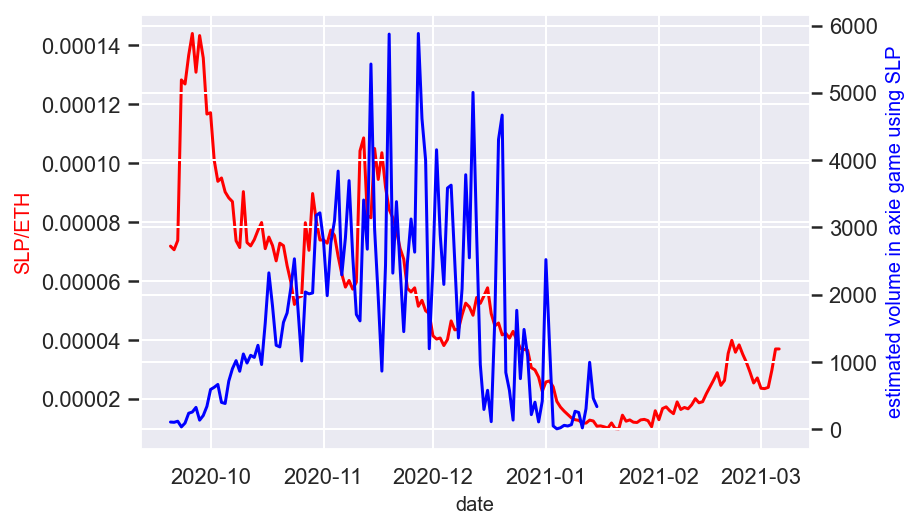

In [35]:
plt.figure(figsize = (18,9))
fig,ax = plt.subplots()
# make a plot
ax.plot(SLP_df['block_date'], SLP_df['exchange_rate'], color="red")
# set x-axis label
ax.set_xlabel("date",fontsize=10)
# set y-axis label
ax.set_ylabel("SLP/ETH",color="red",fontsize=10)

# twin object 
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(axie_volume.index, axie_volume['game'],color="blue")
ax2.set_ylabel("estimated volume in axie game using SLP",color="blue",fontsize=10)
plt.show()

<Figure size 1296x648 with 0 Axes>

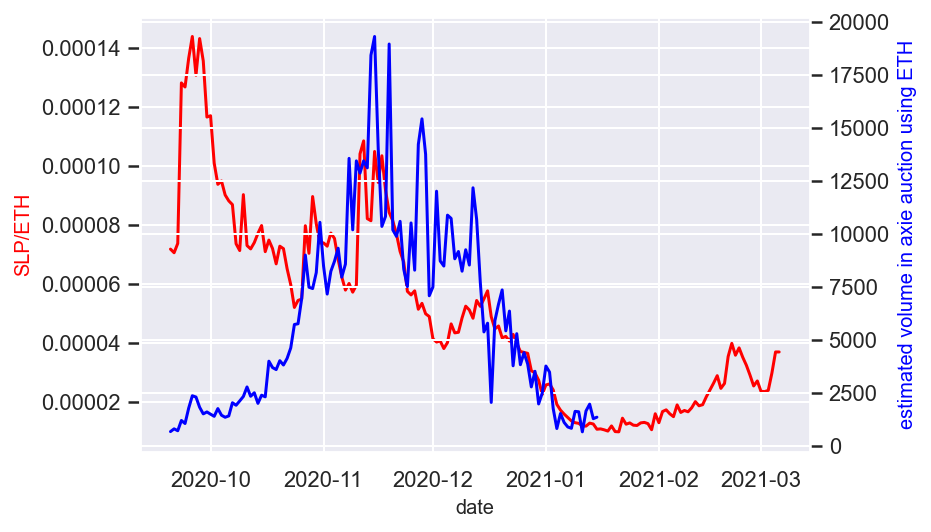

In [36]:
plt.figure(figsize = (18,9))
fig,ax = plt.subplots()
# make a plot
ax.plot(SLP_df['block_date'], SLP_df['exchange_rate'], color="red")
# set x-axis label
ax.set_xlabel("date",fontsize=10)
# set y-axis label
ax.set_ylabel("SLP/ETH",color="red",fontsize=10)

# twin object 
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(axie_volume.index, axie_volume['auction'],color="blue")
ax2.set_ylabel("estimated volume in axie auction using ETH",color="blue",fontsize=10)
plt.show()

- SLP의 가치는 10월 초 고점 이후 감소 추세를 보인다. 
- 게임과 경매 내에서의 거래량이 2020년 4분기 중에 급격하게 증가하다가 올 1월 들어 감소하는 추세
    - 경매 대비 게임 내에서의 거래량 변동이 크게 나타남 -> SLP가 거래에 영향을 미칠 가능성 있음 (나중에 상관성 보기)

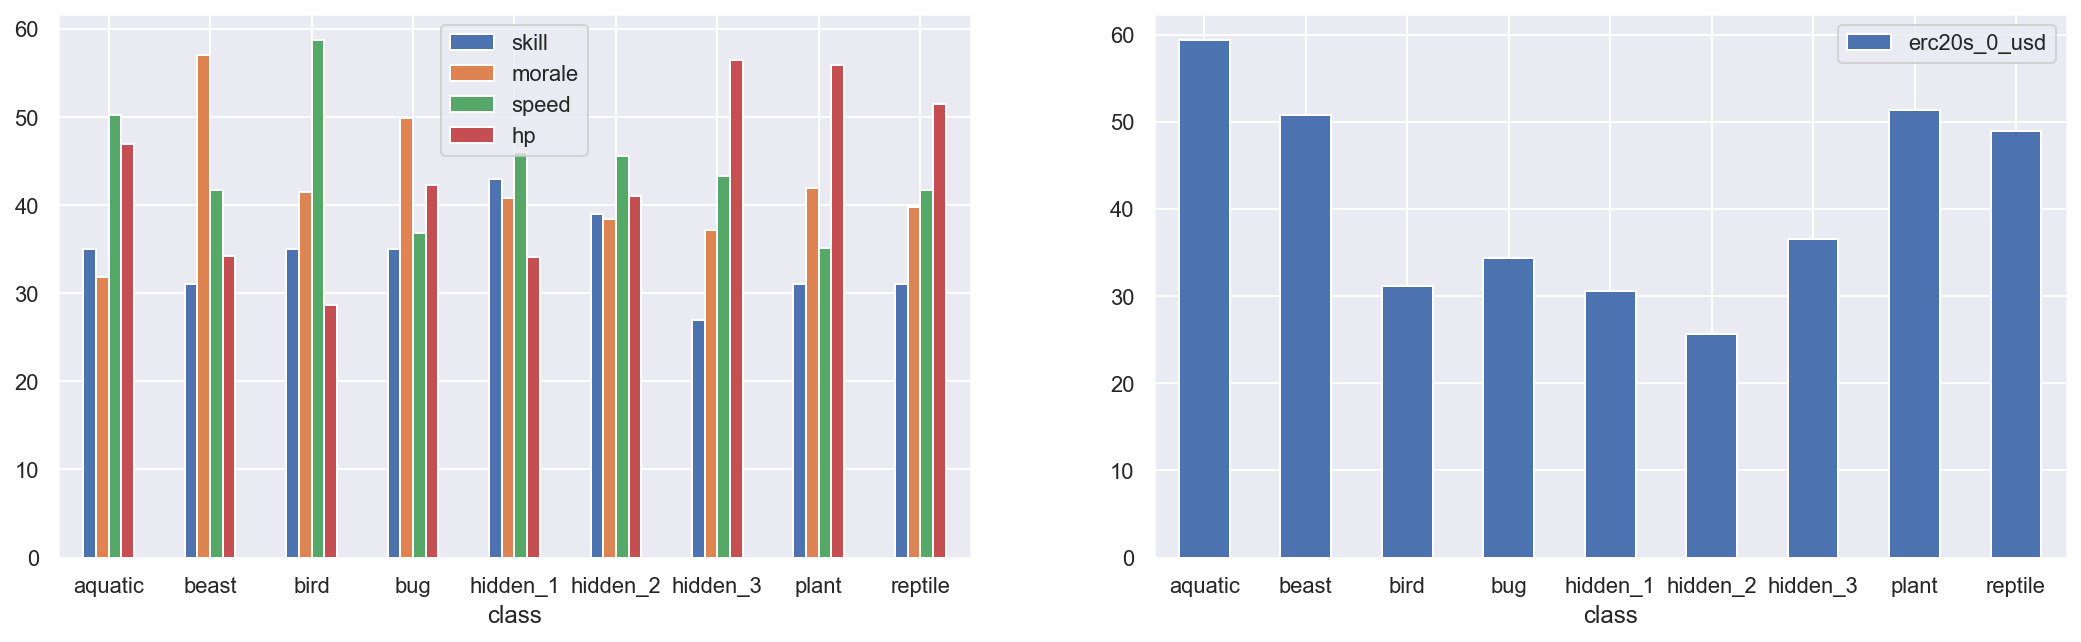

In [37]:
# 클래스별 능력치에 차이가 있는지 살펴본다. 
stat_grouped = axie_df[['skill', 'morale', 'speed', 'hp']].groupby(axie_df['class']).mean()
price_grouped = axie_df[['erc20s_0_usd']].groupby(axie_df['class']).mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

stat_grouped.plot.bar(rot=0, ax=ax[0])
price_grouped.plot.bar(rot=0, ax=ax[1])
plt.show()

- 엑시 클래스별로 스탯 분배에 차이는 있어 보인다. 
- 다음은 2020년 12월에 데이터 한정해서 클래스별 능력치와 가격을 본다

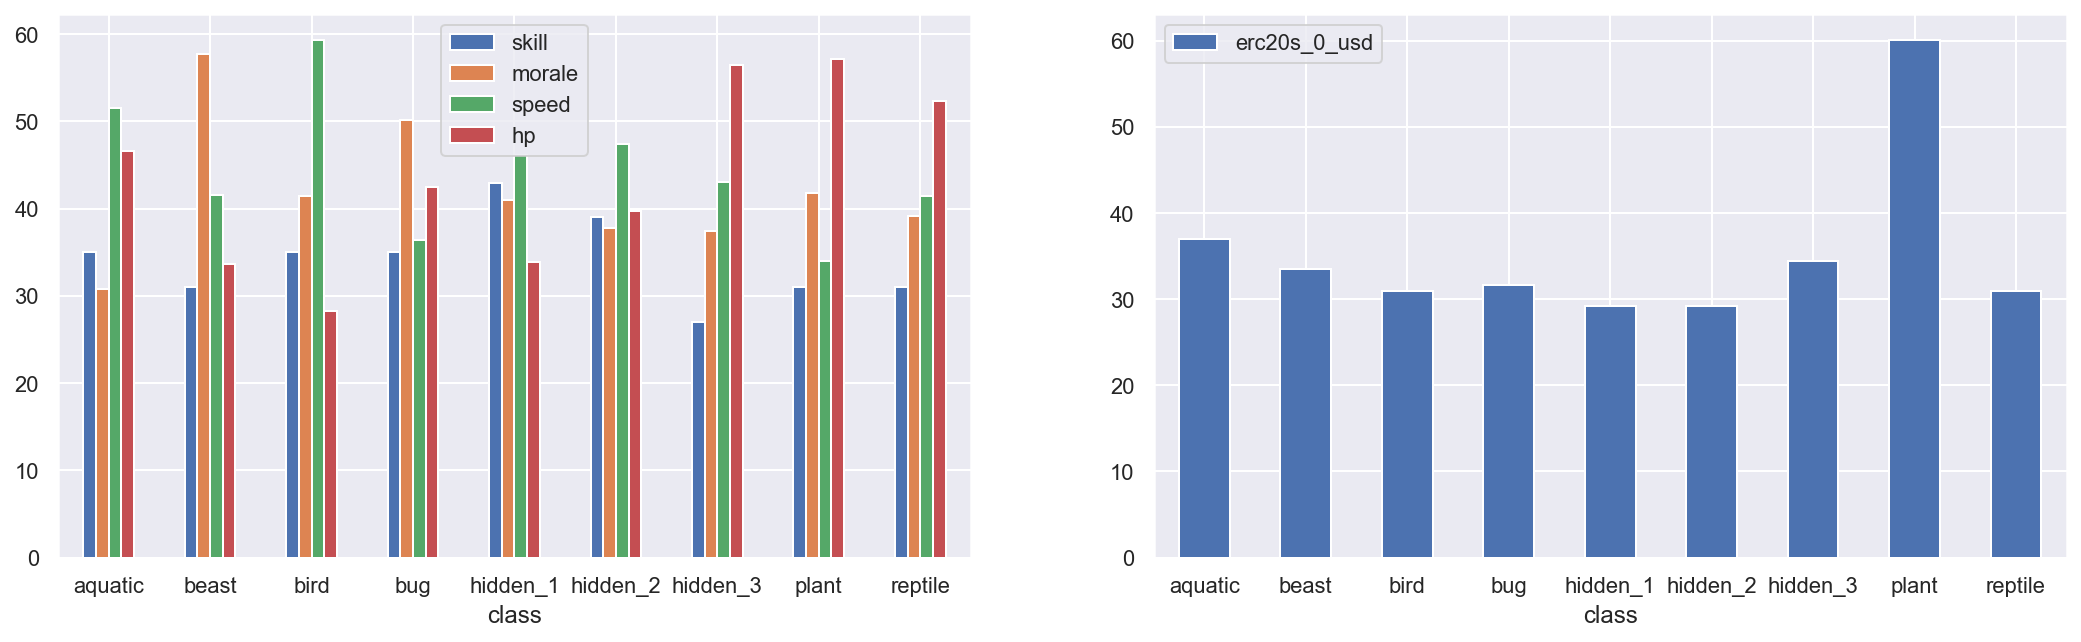

In [38]:
axie_df_202012 = axie_df.loc[(axie_df['year'] == 2020) & (axie_df['month'] == 12), :]
stat_grouped = axie_df_202012[['skill', 'morale', 'speed', 'hp']].groupby(axie_df_202012['class']).mean()
price_grouped = axie_df_202012[['erc20s_0_usd']].groupby(axie_df_202012['class']).mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

stat_grouped.plot.bar(rot=0, ax=ax[0])
price_grouped.plot.bar(rot=0, ax=ax[1])
plt.show()

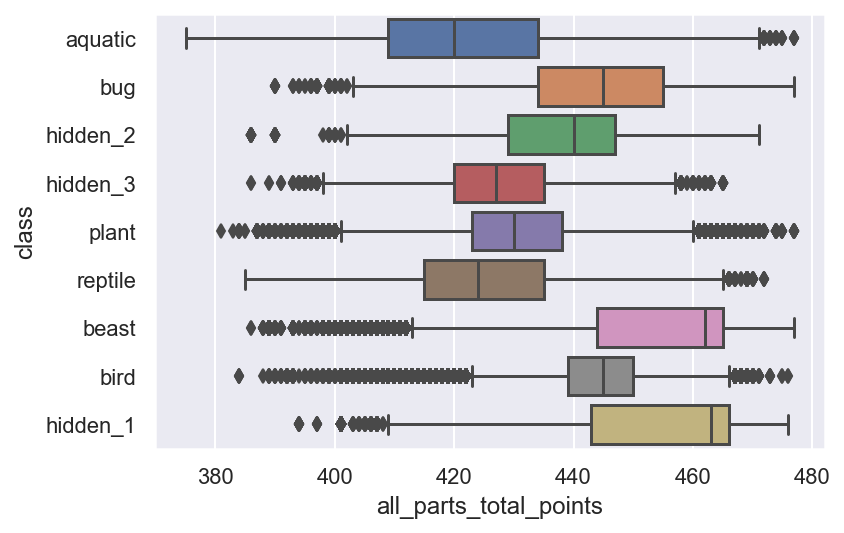

In [39]:
sns.boxplot(x='all_parts_total_points', y= 'class', data=axie_df)
plt.show()

- 일부 데이터의 분포 형태 (histogram)

array([[<AxesSubplot:title={'center':'skill'}>,
        <AxesSubplot:title={'center':'morale'}>,
        <AxesSubplot:title={'center':'speed'}>],
       [<AxesSubplot:title={'center':'hp'}>,
        <AxesSubplot:title={'center':'mouth_move_total_points'}>,
        <AxesSubplot:title={'center':'horn_move_total_points'}>],
       [<AxesSubplot:title={'center':'back_move_total_points'}>,
        <AxesSubplot:title={'center':'tail_move_total_points'}>,
        <AxesSubplot:title={'center':'total_mystic_parts_count'}>],
       [<AxesSubplot:title={'center':'total_bionic_parts_count'}>,
        <AxesSubplot:title={'center':'total_xmas_parts_count'}>,
        <AxesSubplot:title={'center':'erc20s_0_usd'}>]], dtype=object)

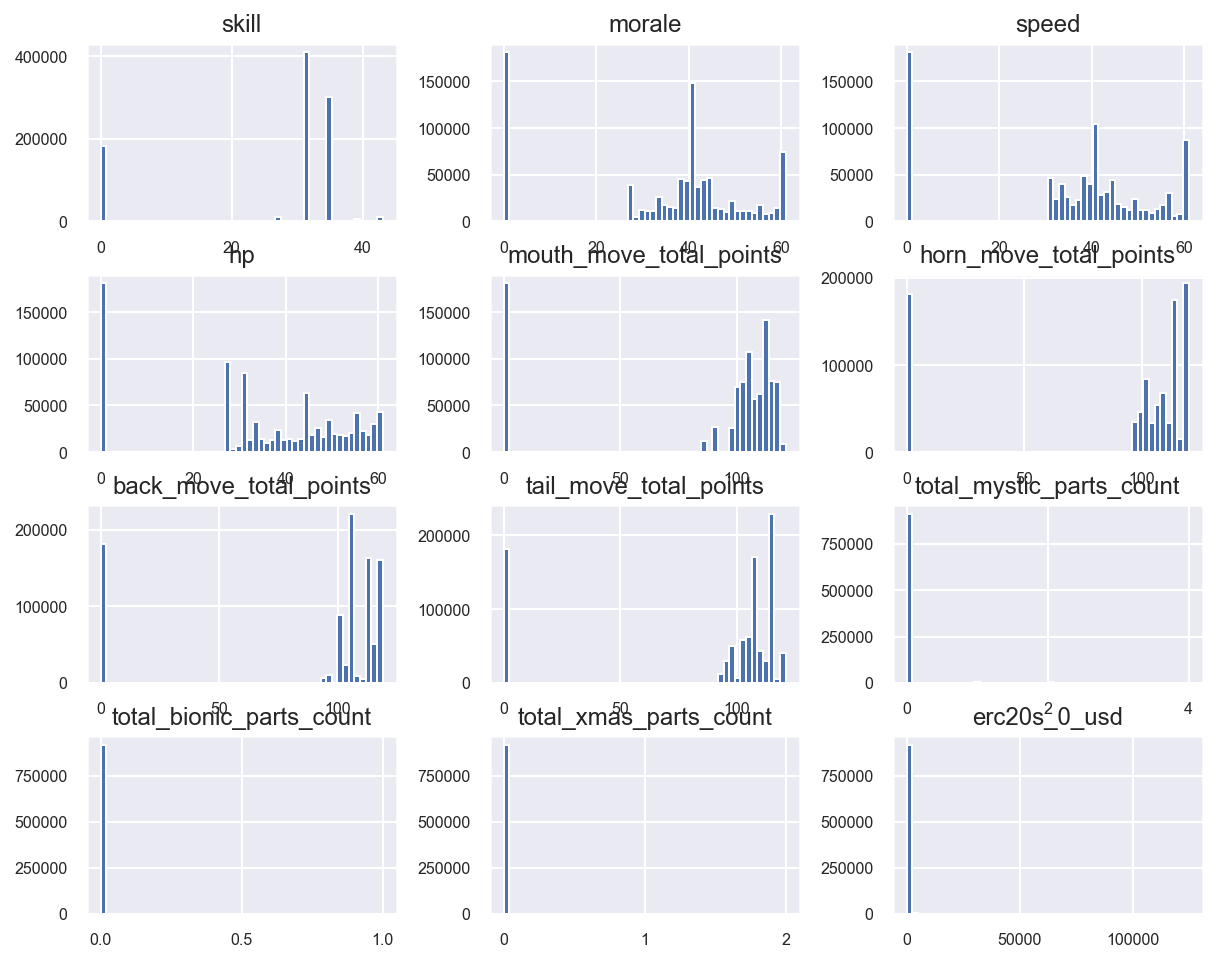

In [52]:
# axie_df_num = axie_df.select_dtypes(include = ['float64', 'int32']) 가스비, exp등이 포함
# 'mouth_move_total_points', 'horn_move_total_points','back_move_total_points','tail_move_total_points', 
axie_df_num = axie_df[['skill', 'morale', 'speed', 'hp', 'mouth_move_total_points', 'horn_move_total_points', 
                       'back_move_total_points','tail_move_total_points',                        
                      'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'erc20s_0_usd']]
axie_df_num.hist(figsize=(10, 8), bins=50, xlabelsize=8, ylabelsize=8)

In [53]:
# mystic_parts, bionic_parts, xmas_parts ?

axie_df.pivot_table(values='item_id', index = ['total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count'], 
                   aggfunc=len)

item_id
total_mystic_parts_count total_bionic_parts_count total_xmas_parts_count         
0                        0                        0                        911785
                                                  1                           429
                                                  2                            36
                         1                        0                             9
1                        0                        0                          5052
2                        0                        0                          1963
3                        0                        0                           431
4                        0                        0                            19

<AxesSubplot:>

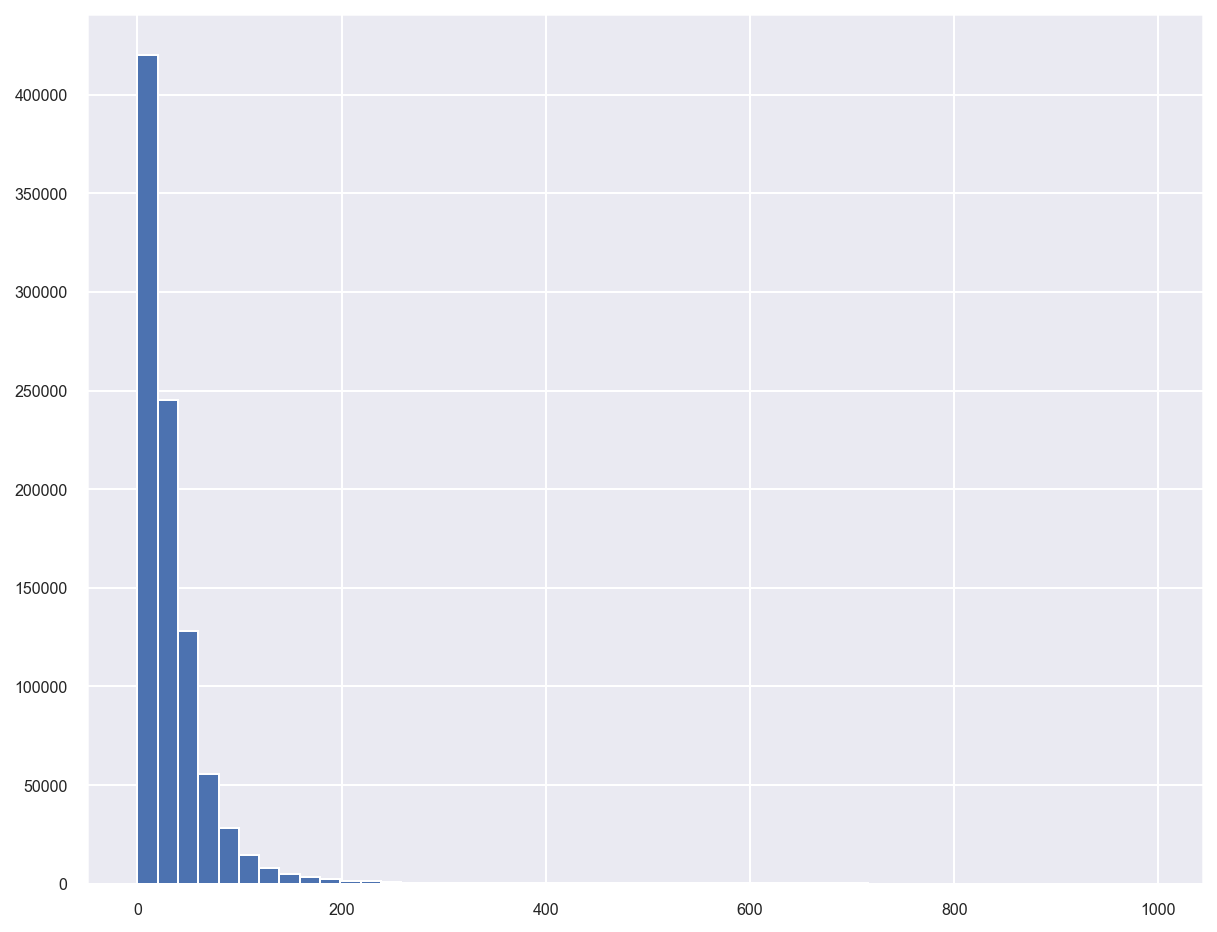

In [41]:
# 가격 중 1000달러 이하만 histogram
axie_df_under_1000.hist(figsize=(10, 8), bins=50, xlabelsize=8, ylabelsize=8)

### 1.3.2 데이터 간의 상관성
- 가격과 다른 변수들 간의 scatter plot을 그려본다.
    - breedCount
    - skill, morale, speed, hp
    - all_parts_total_points 등
       

In [42]:
# axie_df와 SLP를 합친다
axie_df = pd.merge(axie_df, SLP_df, how='left', left_on='transaction_date', right_on='block_date')

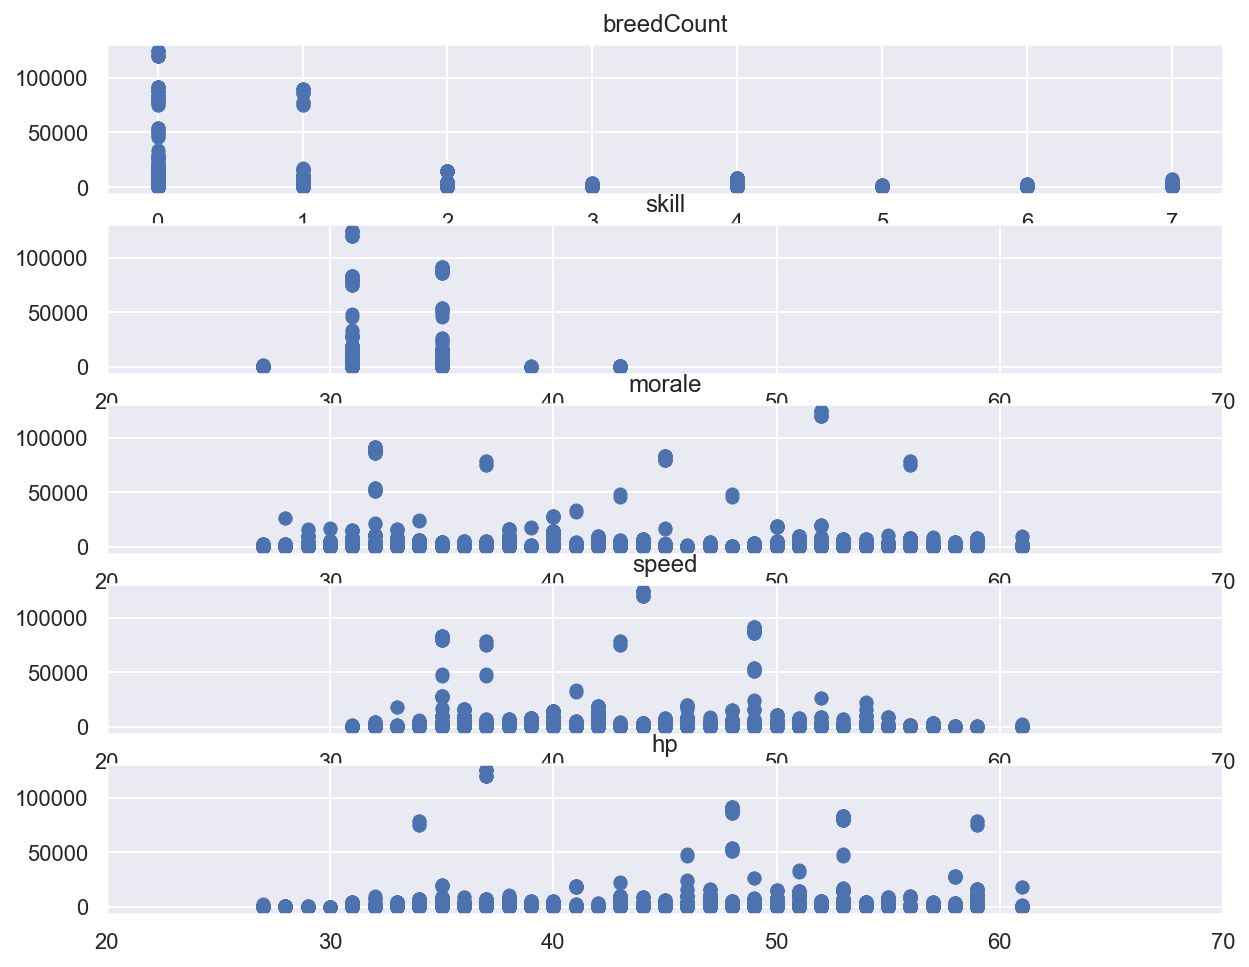

In [43]:
fig, ax = plt.subplots(5, figsize=(10, 8))
ax[0].scatter(x = axie_df['breedCount'], y=axie_df['erc20s_0_usd'])
ax[0].set_title('breedCount')
ax[1].scatter(x = axie_df['skill'], y=axie_df['erc20s_0_usd'])
ax[1].set_title('skill')
ax[1].set_xlim([20, 70])
ax[2].scatter(x = axie_df['morale'], y=axie_df['erc20s_0_usd'])
ax[2].set_title('morale')
ax[2].set_xlim([20, 70])
ax[3].scatter(x = axie_df['speed'], y=axie_df['erc20s_0_usd'])
ax[3].set_title('speed')
ax[3].set_xlim([20, 70])
ax[4].scatter(x = axie_df['hp'], y=axie_df['erc20s_0_usd'])
ax[4].set_title('hp')
ax[4].set_xlim([20, 70])
plt.show()



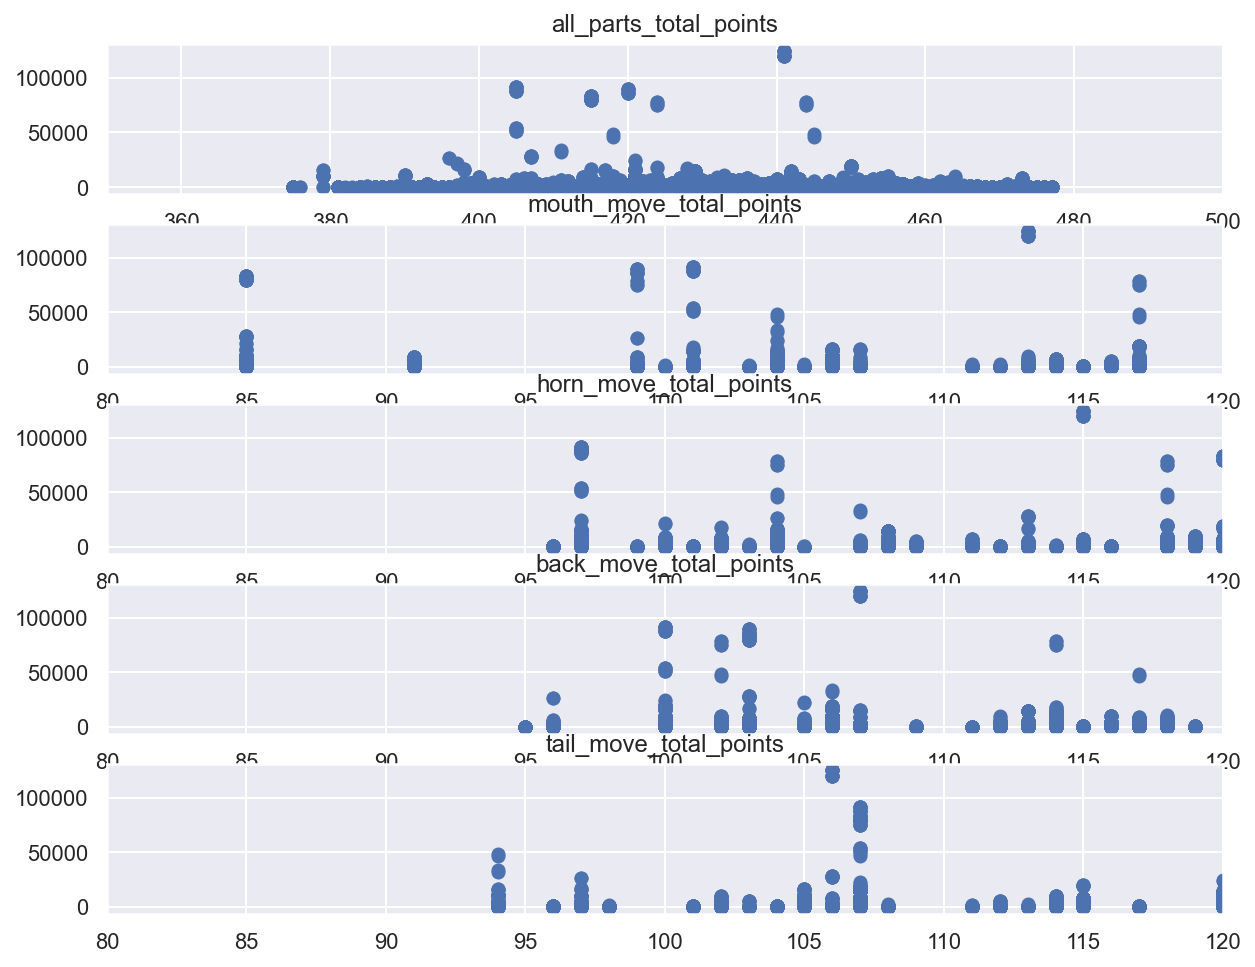

In [44]:
fig, ax = plt.subplots(5, figsize=(10, 8))
ax[0].scatter(x = axie_df['all_parts_total_points'], y=axie_df['erc20s_0_usd'])
ax[0].set_title('all_parts_total_points')
ax[0].set_xlim([350, 500])
ax[1].scatter(x = axie_df['mouth_move_total_points'], y=axie_df['erc20s_0_usd'])
ax[1].set_title('mouth_move_total_points')
ax[1].set_xlim([80, 120])
ax[2].scatter(x = axie_df['horn_move_total_points'], y=axie_df['erc20s_0_usd'])
ax[2].set_title('horn_move_total_points')
ax[2].set_xlim([80, 120])
ax[3].scatter(x = axie_df['back_move_total_points'], y=axie_df['erc20s_0_usd'])
ax[3].set_title('back_move_total_points')
ax[3].set_xlim([80, 120])
ax[4].scatter(x = axie_df['tail_move_total_points'], y=axie_df['erc20s_0_usd'])
ax[4].set_title('tail_move_total_points')
ax[4].set_xlim([80, 120])
plt.show()

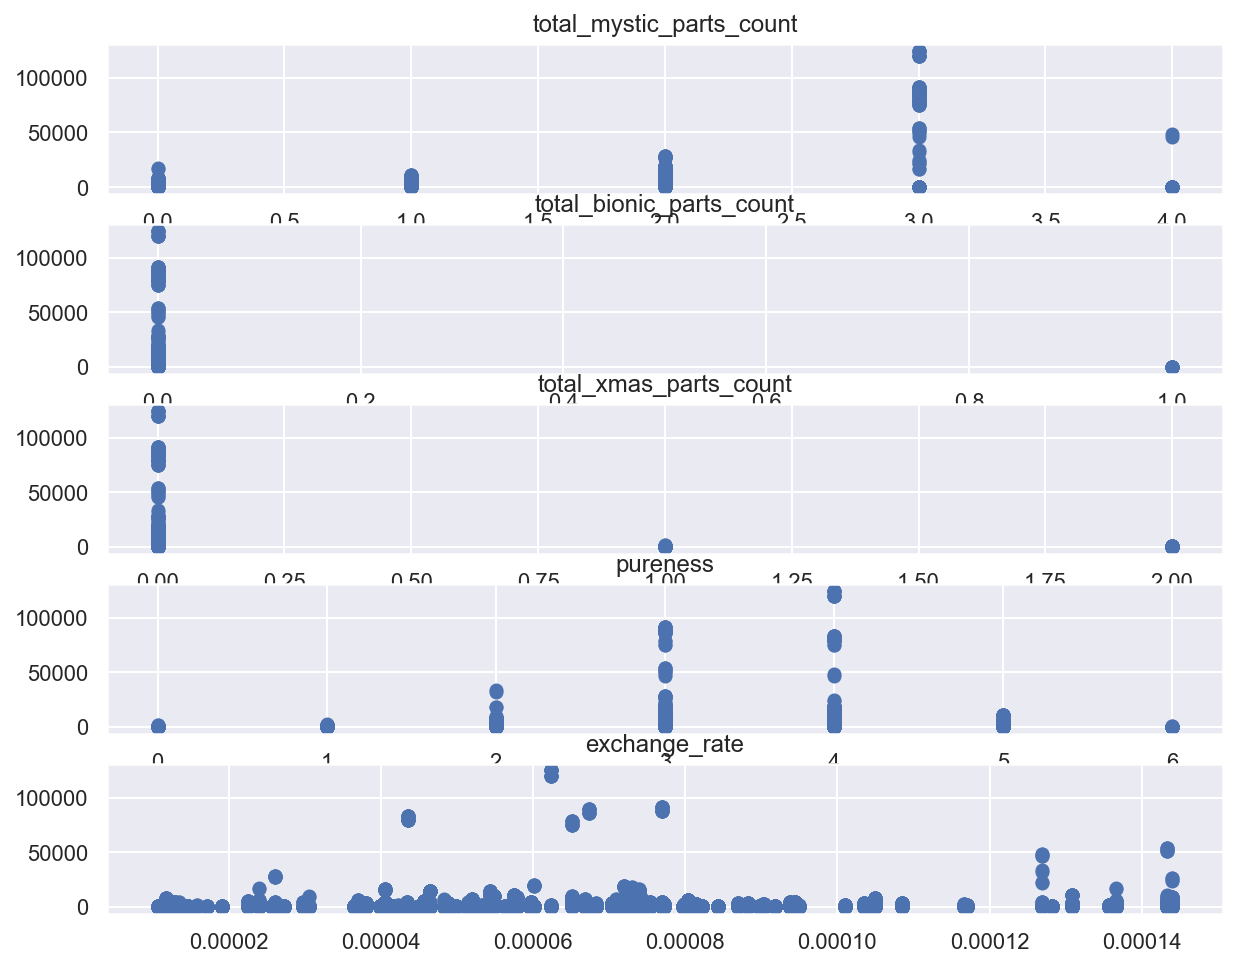

In [45]:
fig, ax = plt.subplots(5, figsize=(10, 8))
ax[0].scatter(x = axie_df['total_mystic_parts_count'], y=axie_df['erc20s_0_usd'])
ax[0].set_title('total_mystic_parts_count')
ax[1].scatter(x = axie_df['total_bionic_parts_count'], y=axie_df['erc20s_0_usd'])
ax[1].set_title('total_bionic_parts_count')
ax[2].scatter(x = axie_df['total_xmas_parts_count'], y=axie_df['erc20s_0_usd'])
ax[2].set_title('total_xmas_parts_count')
ax[3].scatter(x = axie_df['pureness'], y=axie_df['erc20s_0_usd'])
ax[3].set_title('pureness')
ax[4].scatter(x = axie_df['exchange_rate'], y=axie_df['erc20s_0_usd'])
ax[4].set_title('exchange_rate')
plt.show()

- Correlation matrix

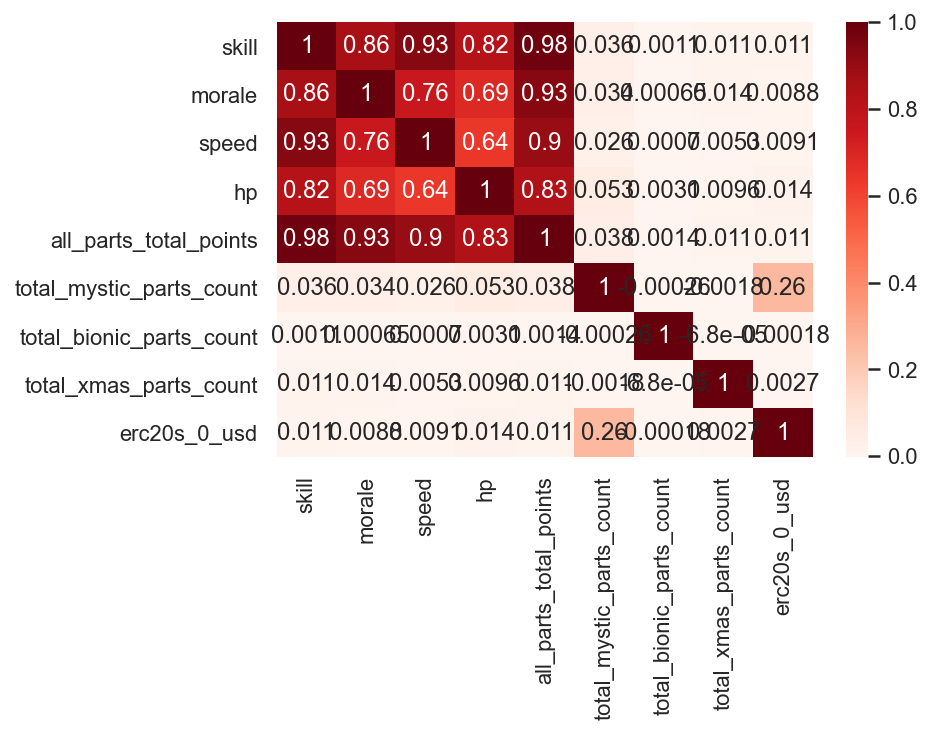

In [46]:
axie_df_num.corr()

#plot the correlation matrix of salary, balance and age in data dataframe.
sns.heatmap(axie_df_num.corr(), annot=True, cmap = 'Reds')
plt.show()


### 1.3.3 가격에 영향을 주는 변수

In [47]:
# 다변량 회귀 분석으로 가격에 영향을 주는 변수를 러프하게 찾아본다.
# 이 때 200 달러 이하로 거래되었던 axie만 대상으로 한다
axie_df_under_200 = axie_df[axie_df['erc20s_0_usd'] < 200]
print('axie NFT total data length:', len(axie_df))
print('axie NFT under 1000$ data length:', len(axie_df_under_1000))
print('axie NFT under 200$ data length:', len(axie_df_under_200))        

axie NFT total data length: 919724
axie NFT under 1000$ data length: 918066
axie NFT under 200$ data length: 910594


#### 다변량 회귀분석
- data pre-processing
    - data scaling: normalized

In [58]:
from sklearn import preprocessing
import statsmodels.api as sm

In [94]:
col_y = ['erc20s_0_usd']
col_x = ['breedCount', 'skill', 'morale', 'speed', 'hp', 'mouth_move_total_points', 
        'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points', 'total_mystic_parts_count', 
        'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness', 'exchange_rate']
dfy = axie_df_under_200[col_y]
dfX = axie_df_under_200[col_x]

In [69]:
trans = preprocessing.MinMaxScaler()
transformed_dfX = trans.fit_transform(dfX)
transformed_dfy = trans.fit_transform(dfy)

In [70]:
transformed_dfX = pd.DataFrame(transformed_dfX, columns=col_x)
transformed_dfy = pd.DataFrame(transformed_dfy, columns=col_y)
transformed_dfX.head(3)

,breedCount,skill,morale,speed,hp,mouth_move_total_points,horn_move_total_points,back_move_total_points,tail_move_total_points,total_mystic_parts_count,total_bionic_parts_count,total_xmas_parts_count,pureness,exchange_rate
0,0.571429,0.813953,0.459016,0.885246,0.770492,0.851240,0.800000,0.882353,0.884298,0.0,0.0,0.0,0.333333,0.458681
1,0.571429,0.813953,0.459016,0.885246,0.770492,0.851240,0.800000,0.882353,0.884298,0.0,0.0,0.0,0.333333,0.458681
2,0.571429,0.813953,0.836066,0.606557,0.672131,0.884298,0.983333,0.932773,0.851240,0.0,0.0,0.0,0.333333,0.458681


In [72]:
X = sm.add_constant(transformed_dfX)
model = sm.OLS(transformed_dfy, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           erc20s_0_usd   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1884.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        09:47:07   Log-Likelihood:             3.9697e+05
No. Observations:              910594   AIC:                        -7.939e+05
Df Residuals:                  910579   BIC:                        -7.937e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 시계열적 요소를 배제
- erc20_usd가치가 200 이하이면서 2020년 12월에 거래된 내역만으로 다시 분석

In [82]:
axie_df_202012_under_200 = axie_df_under_200.loc[(axie_df_under_200['year'] == 2020) & (axie_df_under_200['month'] == 12), :]
len(axie_df_202012_under_200)

269183

In [83]:
dfy = axie_df_202012_under_200[col_y]
dfX = axie_df_202012_under_200[col_x]
# data normalized
transformed_dfX = trans.fit_transform(dfX)
transformed_dfy = trans.fit_transform(dfy)
# make dataframe
transformed_dfX = pd.DataFrame(transformed_dfX, columns=col_x)
transformed_dfy = pd.DataFrame(transformed_dfy, columns=col_y)

X = sm.add_constant(transformed_dfX)
model = sm.OLS(transformed_dfy, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           erc20s_0_usd   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     589.9
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:01:44   Log-Likelihood:             1.4626e+05
No. Observations:              269183   AIC:                        -2.925e+05
Df Residuals:                  269169   BIC:                        -2.924e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

#### 범주형 변수 추가
- class, breedable, erc20s_0_symbol
- breedable은 이미 dummy화된 것 같음

In [95]:
col_x.extend(('class', 'breedable', 'erc20s_0_symbol'))
print(col_x)

['breedCount', 'skill', 'morale', 'speed', 'hp', 'mouth_move_total_points', 'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points', 'total_mystic_parts_count', 'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness', 'exchange_rate', 'class', 'breedable', 'erc20s_0_symbol']


In [99]:
dfy = axie_df_202012_under_200[col_y]
dfX = axie_df_202012_under_200[col_x]

# get dummy variable
dfX = pd.get_dummies(data=dfX, drop_first=True)

X = sm.add_constant(dfX)
model = sm.OLS(dfy, X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           erc20s_0_usd   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     893.9
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:07:47   Log-Likelihood:            -1.2737e+06
No. Observations:              269183   AIC:                         2.547e+06
Df Residuals:                  269159   BIC:                         2.548e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [100]:
col_x = ['breedCount', 'skill', 'morale', 'speed', 'hp', 'mouth_move_total_points', 
        'horn_move_total_points', 'back_move_total_points', 'tail_move_total_points', 'total_mystic_parts_count', 
        'total_bionic_parts_count', 'total_xmas_parts_count', 'pureness', 'exchange_rate']
len(col_x)

14